# Tutorial 06: INSIDE EigenScore Hallucination Detection

This notebook demonstrates how to use INSIDE's EigenScore method for detecting hallucinations in LLM outputs.

## What is EigenScore?

EigenScore measures semantic consistency by analyzing the eigenvalues of the covariance matrix of sentence embeddings extracted from the LLM's internal states. Hallucinated content tends to show higher semantic diversity (semantic inconsistency), resulting in different eigenvalue distributions.

**Key Insight**: Higher EigenScore → Higher hallucination risk

## Setup

In [14]:
import sys
sys.path.append('..')

import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer

# Import INSIDE components
from src.inside import (
    InternalStatesExtractor,
    EigenScore,
    compute_eigenscore,
    HallucinationDetector
)

print("✓ Imports successful")

✓ Imports successful


## Part 1: Understanding Internal States

First, let's understand how to extract internal states from an LLM.

In [15]:
# Load a small model for demonstration
model_name = "gpt2"  # Using GPT-2 for quick demo
print(f"Loading {model_name}...")

model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model.eval()
device = 'cpu'
model.to(device)

print(f"Model loaded. Number of layers: {model.config.n_layer}")
print(f"Hidden size: {model.config.n_embd}")

Loading gpt2...
Model loaded. Number of layers: 12
Hidden size: 768


In [16]:
# Create internal states extractor
# For GPT-2 (12 layers), we'll use the middle layer (layer 6)
extractor = InternalStatesExtractor(
    model=model,
    target_layers=[6],  # Middle layer
    extraction_position='last',
    device=device
)

print("✓ Extractor created")

✓ Extractor created


In [17]:
# Example: Extract embeddings from a sample text
sample_text = """Negligence is a failure to exercise appropriate care. 
It requires duty, breach, causation, and damages. 
The plaintiff must prove all four elements."""

# Extract sentence-level embeddings
from src.inside.internal_states import split_into_sentences

sentences, boundaries = split_into_sentences(sample_text, tokenizer)
print(f"Text split into {len(sentences)} sentences:")
for i, sent in enumerate(sentences, 1):
    print(f"  {i}. {sent}")

# Tokenize and extract
tokens = tokenizer.encode(sample_text, return_tensors='pt').to(device)
embeddings = extractor.extract_embeddings(
    input_ids=tokens,
    sentence_boundaries=boundaries
)

layer_6_embeddings = embeddings[6]
print(f"\nExtracted embeddings shape: {layer_6_embeddings.shape}")
print(f"  (num_sentences={layer_6_embeddings.shape[0]}, hidden_dim={layer_6_embeddings.shape[1]})")

Text split into 3 sentences:
  1. Negligence is a failure to exercise appropriate care
  2. It requires duty, breach, causation, and damages
  3. The plaintiff must prove all four elements

Extracted embeddings shape: torch.Size([3, 768])
  (num_sentences=3, hidden_dim=768)


## Part 2: Computing EigenScore

Now let's compute the EigenScore from these embeddings.

In [18]:
# Compute EigenScore
scorer = EigenScore(normalize=True)
score_details = scorer.compute(layer_6_embeddings, return_details=True)

print("EigenScore Results:")
print(f"  Score: {score_details['score']:.4f}")
print(f"  Num sentences: {score_details['num_sentences']}")
print(f"  Top eigenvalue: {score_details['top_eigenvalue']:.4f}")
print(f"  Condition number: {score_details['condition_number']:.2f}")
print(f"\nEigenvalues (top 5):")
for i, ev in enumerate(score_details['eigenvalues'][:5], 1):
    print(f"  λ{i}: {ev:.4f}")

EigenScore Results:
  Score: 1.3547
  Num sentences: 3
  Top eigenvalue: 0.2460
  Condition number: 1.18

Eigenvalues (top 5):
  λ1: 0.2460
  λ2: 0.2093


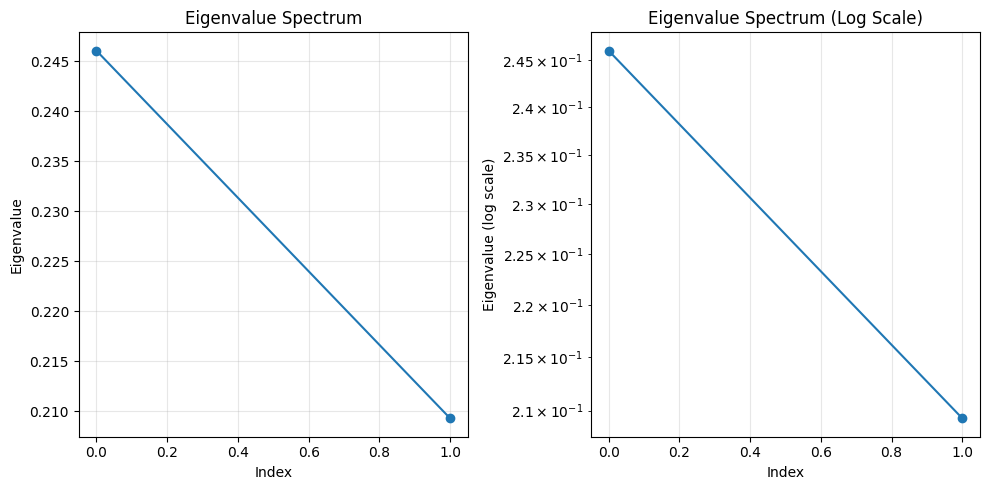

In [19]:
# Visualize eigenvalue distribution
eigenvalues = score_details['eigenvalues']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(eigenvalues, 'o-')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalue Spectrum')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(eigenvalues, 'o-')
plt.xlabel('Index')
plt.ylabel('Eigenvalue (log scale)')
plt.title('Eigenvalue Spectrum (Log Scale)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 3: Comparing Factual vs Hallucinated Content

Let's compare EigenScores for factual and potentially hallucinated content.

In [20]:
# Factual example (consistent, grounded information)
factual_text = """Negligence requires four elements under tort law. 
First, the defendant must owe a duty of care. 
Second, there must be a breach of that duty. 
Third, the breach must cause the plaintiff's injury. 
Fourth, the plaintiff must suffer actual damages."""

# Potentially hallucinated example (inconsistent, contradictory)
hallucinated_text = """Negligence requires seven elements in all jurisdictions. 
The defendant's intent is crucial for establishing negligence. 
Strict liability and negligence are identical legal concepts. 
Damages are optional and not required for negligence claims. 
The duty of care was first established in 1066 AD."""

print("Computing EigenScores...")

Computing EigenScores...


In [21]:
# Compute EigenScore for factual text
factual_embeddings = extractor.extract_from_generations(
    generations=[factual_text],
    tokenizer=tokenizer,
    split_sentences=True
)
factual_score = scorer.compute(factual_embeddings[6])

# Compute EigenScore for hallucinated text
hallucinated_embeddings = extractor.extract_from_generations(
    generations=[hallucinated_text],
    tokenizer=tokenizer,
    split_sentences=True
)
hallucinated_score = scorer.compute(hallucinated_embeddings[6])

print("\nResults:")
print(f"Factual Text EigenScore: {factual_score:.4f}")
print(f"Hallucinated Text EigenScore: {hallucinated_score:.4f}")
print(f"\nDifference: {hallucinated_score - factual_score:.4f}")
print(f"{'✓ Hallucinated has higher score (as expected)' if hallucinated_score > factual_score else '⚠ Unexpected result'}")


Results:
Factual Text EigenScore: 1.5315
Hallucinated Text EigenScore: 1.5609

Difference: 0.0294
✓ Hallucinated has higher score (as expected)


## Part 4: Using the Hallucination Detector

Now let's use the unified `HallucinationDetector` interface.

In [22]:
# Create hallucination detector
detector = HallucinationDetector(
    model=model,
    tokenizer=tokenizer,
    target_layers=[6],
    eigenscore_threshold=5.0,  # Example threshold
    use_adaptive_threshold=True,
    device=device
)

print("✓ Hallucination detector created")

✓ Hallucination detector created


In [23]:
# Test query
test_query = "What are the elements of negligence?"

# Detect hallucination in factual text
result_factual = detector.detect_from_generations(
    query=test_query,
    generations=[factual_text],
    use_clipping=False,
    return_details=True
)

print("Factual Text Detection:")
print(f"  Is Hallucination: {result_factual['is_hallucination']}")
print(f"  EigenScore: {result_factual['eigenscore']:.4f}")
print(f"  Threshold: {result_factual['eigenscore_threshold']:.4f}")
print(f"  Query Intent: {result_factual['query_intent']}")

Factual Text Detection:
  Is Hallucination: False
  EigenScore: 1.5315
  Threshold: 4.3500
  Query Intent: unknown


In [24]:
# Detect hallucination in potentially hallucinated text
result_hallucinated = detector.detect_from_generations(
    query=test_query,
    generations=[hallucinated_text],
    use_clipping=False,
    return_details=True
)

print("Potentially Hallucinated Text Detection:")
print(f"  Is Hallucination: {result_hallucinated['is_hallucination']}")
print(f"  EigenScore: {result_hallucinated['eigenscore']:.4f}")
print(f"  Threshold: {result_hallucinated['eigenscore_threshold']:.4f}")
print(f"  Query Intent: {result_hallucinated['query_intent']}")

Potentially Hallucinated Text Detection:
  Is Hallucination: False
  EigenScore: 1.5609
  Threshold: 4.3500
  Query Intent: unknown


## Part 5: Multi-Generation Detection

The INSIDE paper shows that using multiple generations improves detection accuracy.

In [25]:
# Multiple variations of the same answer
multiple_generations = [
    "Negligence requires duty, breach, causation, and damages.",
    "The four elements of negligence are duty of care, breach, causation, and actual damages.",
    "To prove negligence, one must show: 1) duty, 2) breach, 3) causation, 4) damages."
]

result_multi = detector.detect_from_generations(
    query=test_query,
    generations=multiple_generations,
    use_clipping=False,
    return_details=True
)

print("Multi-Generation Detection:")
print(f"  Num Generations: {result_multi['num_generations']}")
print(f"  Is Hallucination: {result_multi['is_hallucination']}")
print(f"  EigenScore: {result_multi['eigenscore']:.4f}")
print(f"  Threshold: {result_multi['eigenscore_threshold']:.4f}")

Multi-Generation Detection:
  Num Generations: 3
  Is Hallucination: False
  EigenScore: -0.3990
  Threshold: 4.3500


## Part 6: Calibration on Labeled Data

For best results, calibrate the threshold on labeled examples from your domain.

In [26]:
# Example labeled data (you would have more in practice)
factual_examples = [
    ("What is negligence?", [
        "Negligence is a failure to exercise appropriate care.",
        "It is a tort law concept involving breach of duty."
    ]),
    ("What is strict liability?", [
        "Strict liability means liability without fault.",
        "No showing of negligence is required."
    ])
]

hallucinated_examples = [
    ("What is negligence?", [
        "Negligence requires intent and malice.",
        "It was invented in ancient Rome."
    ])
]

# Calibrate
print("Calibrating threshold...")
calibrated_threshold = detector.calibrate(
    factual_examples=factual_examples,
    hallucinated_examples=hallucinated_examples,
    percentile=10.0
)

print(f"\nCalibrated threshold: {calibrated_threshold:.4f}")

Calibrating threshold...
Threshold: 0.90
Precision: 50.00%, Recall: 100.00%
Calibrated EigenScore threshold: 0.90

Calibrated threshold: 0.9018


## Summary

In this tutorial, you learned:

1. **Internal States**: How to extract sentence embeddings from LLM hidden layers
2. **EigenScore**: How to compute semantic consistency using eigenvalue analysis
3. **Detection**: How to detect hallucinations using EigenScore thresholds
4. **Multi-Generation**: How multiple generations improve detection robustness
5. **Calibration**: How to calibrate thresholds on labeled data

## Key Takeaways

- **Higher EigenScore → Higher hallucination risk**
- Multiple generations provide more robust detection
- Calibration on domain-specific data improves accuracy
- Intent-aware thresholds adapt to different query types

## Next Steps

- Tutorial 07: Intent-Aware Retrieval
- Tutorial 08: Combined Self-RAG + INSIDE System